经典的线性回归模型主要用来预测一些存在着线性关系的数据集。回归模型可以理解为：存在一个点集，用一条曲线去拟合它分布的过程。如果拟合曲线是一条直线，则称为线性回归。如果是一条二次曲线，则被称为二次回归。线性回归是回归模型中最简单的一种。 本教程使用PaddlePaddle建立起一个鲍鱼年龄预测模型。

在线性回归中：

（1）假设函数是指，用数学的方法描述自变量和因变量之间的关系，它们之间可以是一个线性函数或非线性函数。 在本次线性回顾模型中，我们的假设函数为 Y’= wX+b ，其中，Y’表示模型的预测结果（预测的鲍鱼年龄），用来和真实的Y区分。模型要学习的参数即：w,b。

（2）损失函数是指，用数学的方法衡量假设函数预测结果与真实值之间的误差。这个差距越小预测越准确，而算法的任务就是使这个差距越来越小。 建立模型后，我们需要给模型一个优化目标，使得学到的参数能够让预测值Y’尽可能地接近真实值Y。这个实值通常用来反映模型误差的大小。不同问题场景下采用不同的损失函数。 对于线性模型来讲，最常用的损失函数就是均方误差（Mean Squared Error， MSE）。

（3）优化算法：神经网络的训练就是调整权重（参数）使得损失函数值尽可能得小，在训练过程中，将损失函数值逐渐收敛，得到一组使得神经网络拟合真实模型的权重（参数）。所以，优化算法的最终目标是找到损失函数的最小值。而这个寻找过程就是不断地微调变量w和b的值，一步一步地试出这个最小值。 常见的优化算法有随机梯度下降法（SGD）、Adam算法等等


# **Step1.数据准备**

**认识数据：**

![](https://ai-studio-static-online.cdn.bcebos.com/bba24e932f7547e38de93fce393fac0f166861451ac24080b69cd3ff2cb4dbf8)

数据集共4177行，每行9列

前8列用来描述鲍鱼的各种信息，分别是性别、长度、直径、高度、总重量、皮重、内脏重量、克重，最后一列为该鲍鱼的年龄


**数据准备：**

1.从文件中加载数据

2.对数据进行归一化

3.构造数据集提供器

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
# 将性别（M：雄性，F：雌性，I：未成年）映射成数字
sex_dict = { 'I': 0, 'M': 1, 'F': 2 }
def sex_map(sex):
    return sex_dict[sex]

txt_path='data/data361/AbaloneAgePrediction.txt'
df=pd.read_csv(txt_path,names=['性别','长度','直径','高度','总重量','皮重','内脏重量','克重','年龄'],converters={'性别':sex_map})
df.head(10)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
性别      4177 non-null int64
长度      4177 non-null float64
直径      4177 non-null float64
高度      4177 non-null float64
总重量     4177 non-null float64
皮重      4177 non-null float64
内脏重量    4177 non-null float64
克重      4177 non-null float64
年龄      4177 non-null int64
dtypes: float64(7), int64(2)
memory usage: 293.8 KB


In [18]:
# pandas归一化
df=(df-df.min())/(df.max()-df.min())
df.head(5)

,性别,长度,直径,高度,总重量,皮重,内脏重量,克重,年龄
0,0.5,0.513514,0.521008,0.084071,0.181335,0.150303,0.132324,0.147982,0.500000
1,0.5,0.371622,0.352941,0.079646,0.079157,0.066241,0.063199,0.068261,0.214286
2,1.0,0.614865,0.613445,0.119469,0.239065,0.171822,0.185648,0.207773,0.285714
3,0.5,0.493243,0.521008,0.110619,0.182044,0.144250,0.149440,0.152965,0.321429
4,0.0,0.344595,0.336134,0.070796,0.071897,0.059516,0.051350,0.053313,0.214286


In [ ]:
#pandas划分测试集和训练集,x_train,y_train,x_test,y_test

import paddle
import paddle.fluid as fluid
from sklearn.model_selection import train_test_split
import paddle.fluid.dygraph as dygraph
from paddle.fluid.dygraph import Linear

# 分割训练集、测试集
x=df.iloc[:,:-1].values
y=df.iloc[:,-1:].values
#x.reset_index(drop=True,inplace=True)
#y.reset_index(drop=True,inplace=True)
#print(x.shape,y.shape)
x_train, x_test, y_train,y_test=train_test_split(x,y,test_size=0.1,random_state=42)
# 自定义reader,每次返回一个样本数据
def reader_creator(_X, _Y):
    def reader():
        for _x, _y in zip(_X, _Y):
            yield [_x, _y]          #返回Iterable对象
    return reader
# 一个minibatch中有16个数据
BATCH_SIZE = 16

#定义了用于训练与验证的数据提供器。提供器每次读入一个大小为BATCH_SIZE的数据批次。
#BATCH_SIZE个数据项组成一个mini batch。
train_reader = paddle.batch(reader_creator(x_train, y_train),
                            batch_size=BATCH_SIZE)
test_reader = paddle.batch(reader_creator(x_test, y_test), 
                           batch_size=BATCH_SIZE)

In [19]:
#pandas划分测试集和训练集,train_data,eval_data

import paddle
import paddle.fluid as fluid
from sklearn.model_selection import train_test_split
import paddle.fluid.dygraph as dygraph
from paddle.fluid.dygraph import Linear
train_data,eval_data=train_test_split(df,test_size=0.1,random_state=42)
BATCH_SIZE = 16
def reader_creator2(data):
    def reader():
        for row in data.values:           
            yield [row[:-1], row[-1:]]          #返回Iterable对象
    return reader
train_reader = paddle.batch(reader_creator2(train_data),
                            batch_size=BATCH_SIZE)
test_reader = paddle.batch(reader_creator2(eval_data), 
                           batch_size=BATCH_SIZE)    

In [1]:
#原方法读取数据
# 读取文件
import numpy as np
import os
import matplotlib.pyplot as plt

data_X = []
data_Y = []
# 将性别（M：雄性，F：雌性，I：未成年）映射成数字
sex_map = { 'I': 0, 'M': 1, 'F': 2 }
with open ('data/data361/AbaloneAgePrediction.txt') as f:
    for line in f.readlines():
        line = line.split(',')
        line[0] = sex_map[line[0]]
        data_X.append(line[:-1])
        data_Y.append(line[-1:])
# 转换为nparray
data_X = np.array(data_X, dtype='float32')
data_Y = np.array(data_Y, dtype='float32')
# 检查大小
print('data shape', data_X.shape, data_Y.shape)
print('data_x shape[1]', data_X.shape[1])



data shape (4177, 8) (4177, 1)
data_x shape[1] 8


In [2]:
# 原来归一化
for i in range(data_X.shape[1]):
    _min = np.min(data_X[:,i])                            #每一列的最小值
    _max = np.max(data_X[:,i])                            #每一列的最大值
    data_X[:, i] = (data_X[:, i] - _min) / (_max - _min)  #归一化到0-1之间

In [3]:
#原来划分训练和测试
import paddle
import paddle.fluid as fluid
from sklearn.model_selection import train_test_split
import paddle.fluid.dygraph as dygraph
from paddle.fluid.dygraph import Linear

# 分割训练集、测试集
X_train, X_test, y_train, y_test = train_test_split(data_X,          #被划分的样本特征集
                                                    data_Y,          #被划分的样本标签
                                                    test_size=0.2,   #测试集占比
                                                    random_state=1)  #随机数种子，在需要重复试验的时候，保证得到一组一样的随机数
# 自定义reader,每次返回一个样本数据
def reader_creator(_X, _Y):
    def reader():
        for _x, _y in zip(_X, _Y):
            yield [_x, _y]          #返回Iterable对象
    return reader
    
# 一个minibatch中有16个数据
BATCH_SIZE = 16

#定义了用于训练与验证的数据提供器。提供器每次读入一个大小为BATCH_SIZE的数据批次。
#BATCH_SIZE个数据项组成一个mini batch。
train_reader = paddle.batch(reader_creator(X_train, y_train),
                            batch_size=BATCH_SIZE)
test_reader = paddle.batch(reader_creator(X_test, y_test), 
                           batch_size=BATCH_SIZE)

# **Step2.网络配置**

**（1）网络搭建**：对于线性回归来讲，它就是一个从输入到输出的简单的全连接层。

对于鲍鱼年龄预测数据集，假设鲍鱼属性和年龄之间的关系可以被属性间的线性组合描述。

![](https://ai-studio-static-online.cdn.bcebos.com/f3f567e7aa7a499fb3abb767aaaa1b943eed373cf4694d87beb382e161ea8edc)

![](https://ai-studio-static-online.cdn.bcebos.com/f6c44a96e1624828829bbd438c29c17ead9ecc45c68b4310bfbbb0a4dc96c3fe)


In [4]:

# 定义动态图
class Regressor(fluid.dygraph.Layer):
    def __init__(self, name_scope):
        super(Regressor, self).__init__(name_scope)
        name_scope = self.full_name()
        # 定义一层全连接层，输出维度是1，激活函数为None，即不使用激活函数
        self.fc = Linear(input_dim=8, output_dim=1, act=None)
    
    # 网络的前向计算函数
    def forward(self, inputs):
        x = self.fc(inputs)
        return x

# **Step3.网络训练 & Step4.网络评估**

In [5]:



def draw_train_process(iters,train_costs):
    title="training cost"
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=14)
    plt.ylabel("cost", fontsize=14)
    plt.plot(iters, train_costs,color='red',label='training cost') 
    plt.grid()
    plt.show()

epoch: 0, iter: 0, loss is: [113.00326]
epoch: 0, iter: 50, loss is: [4.8912306]
epoch: 0, iter: 100, loss is: [6.56061]
epoch: 0, iter: 150, loss is: [16.880997]
epoch: 0, iter: 200, loss is: [5.9421334]
Test:0, Cost:6.47945
epoch: 1, iter: 0, loss is: [12.126436]
epoch: 1, iter: 50, loss is: [4.5091505]
epoch: 1, iter: 100, loss is: [5.9230776]
epoch: 1, iter: 150, loss is: [16.46431]
epoch: 1, iter: 200, loss is: [5.5849934]
Test:1, Cost:6.19403
epoch: 2, iter: 0, loss is: [11.347308]
epoch: 2, iter: 50, loss is: [4.312611]
epoch: 2, iter: 100, loss is: [5.352735]
epoch: 2, iter: 150, loss is: [16.137175]
epoch: 2, iter: 200, loss is: [5.2896347]
Test:2, Cost:5.96544
epoch: 3, iter: 0, loss is: [10.697964]
epoch: 3, iter: 50, loss is: [4.144273]
epoch: 3, iter: 100, loss is: [4.883069]
epoch: 3, iter: 150, loss is: [15.873074]
epoch: 3, iter: 200, loss is: [5.0420103]
Test:3, Cost:5.78210
epoch: 4, iter: 0, loss is: [10.157059]
epoch: 4, iter: 50, loss is: [3.9992423]
epoch: 4, iter

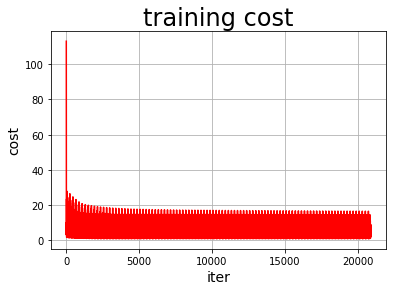

In [13]:
from visualdl import LogWriter

iter=0
iters=[]
train_costs=[]
#训练轮数：所有训练数据的一个前向传递和一个后向传递为一轮
EPOCH_NUM=100
#模型保存路径
model_save_dir = "work/fit_a_line_inference"
logdir='log/fit'
train_loss_logger=LogWriter(logdir=logdir)
eval_loss_logger=LogWriter(logdir=logdir)

# 定义飞桨动态图的工作环境
with fluid.dygraph.guard(place = fluid.CUDAPlace(0)):
#with fluid.dygraph.guard():
    # 声明定义好的线性回归模型
    model = Regressor("Regressor")
   
    
    # 定义优化算法，这里使用随机梯度下降-SGD
    opt = fluid.optimizer.SGD(learning_rate=0.1, parameter_list=model.parameters())
  
    # 定义外层循环
    for epoch_id in range(EPOCH_NUM):
        #if epoch_id>5:break
        model.train() # 开启模型训练模式   
        for batch_id, data in enumerate(train_reader()):
            #if batch_id>2:break
            test_x = np.array([x[0] for x in data],np.float32)
            test_y = np.array([x[1] for x in data],np.float32)
            #print('test_x {} test_y {}'.format(test_x,test_y))
            # 将numpy数据转为飞桨动态图variable形式
            features = dygraph.to_variable(test_x)
            ages= dygraph.to_variable(test_y)
            
            # 前向计算
            predicts = model(features)
            # 计算损失
            loss = fluid.layers.square_error_cost(predicts, label=ages)
            avg_loss = fluid.layers.mean(loss)

            iter=iter+1
            iters.append(iter)
            train_costs.append(avg_loss.numpy())
            
            if batch_id%50==0:
                print("epoch: {}, iter: {}, loss is: {}".format(epoch_id, batch_id, avg_loss.numpy()))
                train_loss_logger.add_scalar('train_loss',step=iter,value=avg_loss.numpy())
            
            # 反向传播
            avg_loss.backward()
            # 最小化loss,更新参数
            opt.minimize(avg_loss)
            # 清除梯度
            model.clear_gradients()

        test_costs = []
        model.eval()
        for batch_id,data in enumerate(test_reader()):
            test_x = np.array([x[0] for x in data],np.float32)
            test_y = np.array([x[1] for x in data],np.float32)
            features = dygraph.to_variable(test_x)
            ages = dygraph.to_variable(test_y)
            # 前向计算
            predicts = model(features)
            # 计算损失
            loss = fluid.layers.square_error_cost(predicts, label=ages)
            avg_loss = fluid.layers.mean(loss)
               
            test_costs.append(avg_loss.numpy())
           
        test_cost = (sum(test_costs) / len(test_costs)) 
        print('Test:%d, Cost:%0.5f' % (epoch_id, test_cost))


print('训练模型保存完成！')



print ('save models to %s' % (model_save_dir))
# 保存模型
fluid.save_dygraph(model.state_dict(), model_save_dir)

draw_train_process(iters,train_costs)

# **Step5.模型预测**


**可视化真实值与预测值方法定义**

In [14]:

def draw_infer_result(groud_truths,infer_results):
    title='abalone'
    plt.title(title, fontsize=24)
    x = np.arange(1,20) 
    y = x
    plt.plot(x, y)
    plt.xlabel('ground truth', fontsize=14)
    plt.ylabel('infer result', fontsize=14)
    plt.scatter(groud_truths, infer_results,color='green',label='training cost') 
    plt.grid()
    plt.show()

**开始预测**


No.0: infer result is 9.16,ground truth is 10.00
No.1: infer result is 7.17,ground truth is 8.00
No.2: infer result is 8.01,ground truth is 9.00
No.3: infer result is 9.16,ground truth is 10.00
No.4: infer result is 11.02,ground truth is 16.00
No.5: infer result is 6.14,ground truth is 6.00
No.6: infer result is 11.87,ground truth is 9.00
No.7: infer result is 10.58,ground truth is 10.00
No.8: infer result is 10.08,ground truth is 12.00
No.9: infer result is 9.10,ground truth is 9.00
平均误差为: [4.0149097]


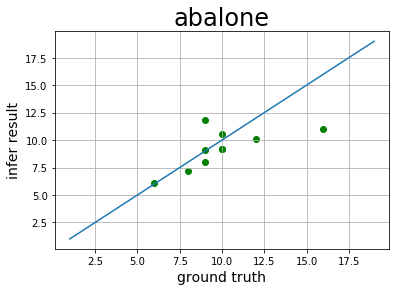

TypeError: add_pr_curve() missing 1 required positional argument: 'step'

In [15]:
with dygraph.guard():
    # 参数为保存模型参数的文件地址
    model = Regressor("Regressor")
    model_dict, _ = fluid.load_dygraph(model_save_dir)
    model.load_dict(model_dict)
    model.eval()

    INFER_BATCH_SIZE=10
    infer_reader = paddle.batch(reader_creator(X_test, y_test), batch_size=INFER_BATCH_SIZE)
    #从infer_reader中分割x
    infer_data = next(infer_reader())
    infer_x = np.array([data[0] for data in infer_data]).astype("float32")
    infer_y= np.array([data[1] for data in infer_data]).astype("float32")

    infer_x = dygraph.to_variable(infer_x)

    results = model(infer_x)

    infer_results=[]    #预测值
    groud_truths=[]     #真实值
    sum_cost=0
    for i in range(INFER_BATCH_SIZE):
        infer_result=results[i]      #经过预测后的值

        ground_truth=infer_y[i]          #真实值
        
        infer_results.append(infer_result.numpy())
        groud_truths.append(ground_truth)


        print("No.%d: infer result is %.2f,ground truth is %.2f" % (i, infer_result.numpy(),ground_truth))
        cost=np.power(infer_result.numpy()-ground_truth,2)
        sum_cost+=cost
        

    print("平均误差为:",sum_cost/INFER_BATCH_SIZE)
       
    draw_infer_result(groud_truths,infer_results)